# Double source plane cosmology forecast

In [1]:
# import standard python modules
import numpy as np
import corner
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# matplotlib configs
from pylab import rc

rc("axes", linewidth=2)
rc("xtick", labelsize=15)
rc("ytick", labelsize=15)

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [2]:
from hierarc.Likelihood.LensLikelihood.double_source_plane import (
    beta_double_source_plane,
    beta2theta_e_ratio,
)

# define a cosmology
cosmology = "FwCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
kwargs_cosmo_true = {"h0": 70, "om": 0.3, "w": -1}  # cosmological model of the forecast

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)


# =====================================
# Settings for pupulation of DSP
# =====================================

# number of double source plane lenses
num_dspl = 87

sigma_beta = 0.05  # relative precision on Einstein radius ratio
gamma_pl_mean = 2.05
gamma_pl_sigma = 0.05

lambda_mst_mean = 1
lambda_mst_sigma = 0.0


def draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma):
    """
    draw the likelihood object of a double source plane lens
    """
    z_lens = np.random.uniform(low=0.2, high=0.5)
    z_source1 = np.random.uniform(low=z_lens + 0.2, high=1.5)
    z_source2 = np.random.uniform(low=z_source1, high=3)
    beta = beta_double_source_plane(z_lens, z_source1, z_source2, cosmo_true)
    # TODO: translate to measured Einstein radius ratio
    lambda_mst = np.random.normal(lambda_mst_mean, lambda_mst_sigma)
    gamma_pl = np.random.normal(gamma_pl_mean, gamma_pl_sigma)
    beta_transformed = beta2theta_e_ratio(
        beta_dsp=beta, gamma_pl=gamma_pl, lambda_mst=lambda_mst
    )
    beta_measured = beta_transformed + np.random.normal(
        loc=0, scale=sigma_beta * beta_transformed
    )
    kwargs_likelihood = {
        "z_lens": z_lens,
        "z_source": z_source1,
        "z_source2": z_source2,
        "beta_dspl": beta_measured,
        "sigma_beta_dspl": sigma_beta * beta,
        "likelihood_type": "DSPL",
    }
    return kwargs_likelihood


kwargs_dspl_list = []

for i in range(num_dspl):
    kwargs_dspl_list.append(
        draw_lens(lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma)
    )

## hierArc sampling settings

In [3]:
# sampling settings
n_walkers = 100
n_run = 200
n_burn = 200

cosmology = "FwCDM"

kwargs_mean_start = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3, "w": -1},
    "kwargs_lens": {
        "lambda_mst": lambda_mst_mean,
        "lambda_mst_sigma": lambda_mst_sigma,
        "gamma_pl_mean": gamma_pl_mean,
        "gamma_pl_sigma": gamma_pl_sigma,
    },
}

kwargs_sigma_start = {
    "kwargs_cosmo": {"h0": 10, "om": 0.05, "w": 0.2},
    "kwargs_lens": {
        "lambda_mst": 0.1,
        "lambda_mst_sigma": 0.01,
        "gamma_pl_mean": 0.1,
        "gamma_pl_sigma": 0.01,
    },
}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w": -2},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w": 0},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},
    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5},
    "kwargs_fixed_lens": {
        "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma,
    },
}


# TODO: add gamma_pl population sampling
# TODO: add lambda_mst_sigma sampling

# joint options for hierArc sampling


kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "GAUSSIAN",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}


kwargs_sampler = {
    "custom_prior": None,
    "interpolate_cosmo": False,
    "num_redshift_interp": 100,
    "cosmo_fixed": None,
}

In [4]:
mcmc_sampler = MCMCSampler(
    kwargs_dspl_list,
    cosmology=cosmology,
    kwargs_model=kwargs_model,
    kwargs_bounds=kwargs_bounds,
    **kwargs_sampler
)

likelihood = mcmc_sampler.chain
param = mcmc_sampler.param

kwargs_test = {
    "kwargs_cosmo": {"h0": 70, "om": 0.3, "w": -1},
    "kwargs_lens": {
        "lambda_mst": lambda_mst_mean,
        "lambda_mst_sigma": lambda_mst_sigma,
        "gamma_pl_mean": gamma_pl_mean + 0.0,
        "gamma_pl_sigma": gamma_pl_sigma,
    },
}

args = param.kwargs2args(**kwargs_test)

%timeit likelihood.likelihood(args)

90.7 ms ± 763 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%load_ext line_profiler

# %lprun -f likelihood.likelihood likelihood.likelihood(args)  # first level

from hierarc.Likelihood.lens_sample_likelihood import LensSampleLikelihood
# %lprun -f LensSampleLikelihood.log_likelihood likelihood.likelihood(args)  # second level


from hierarc.Likelihood.hierarchy_likelihood import LensLikelihood
# %lprun -f LensLikelihood.lens_log_likelihood likelihood.likelihood(args)  # third level

# %lprun -f LensLikelihood.hyper_param_likelihood likelihood.likelihood(args)  # 4th level

%lprun -f LensLikelihood.log_likelihood_single likelihood.likelihood(args)  # 5th level





100%|██████████| 400/400 [9:29:56<00:00,  6.13s/it]      


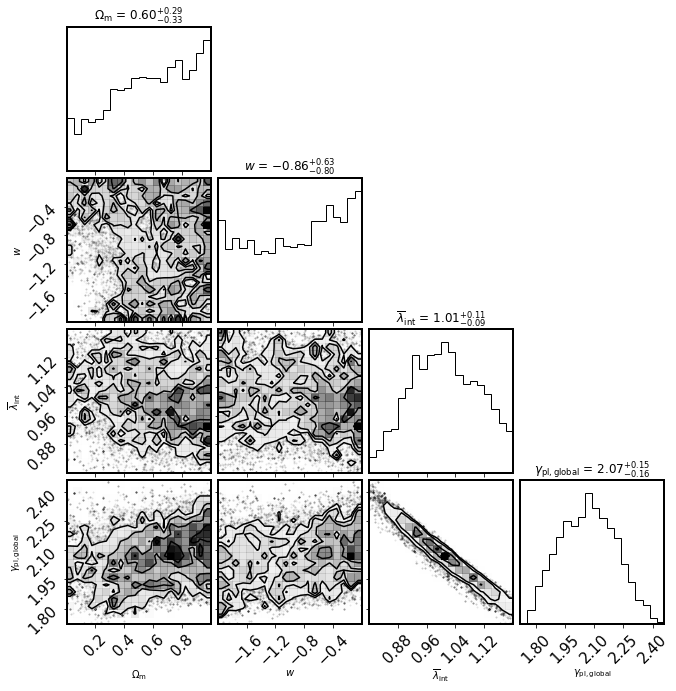

In [6]:
mcmc_samples, log_prob = mcmc_sampler.mcmc_emcee(
    n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start
)

corner.corner(
    mcmc_samples, show_titles=True, labels=mcmc_sampler.param_names(latex_style=True)
)
plt.show()